# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг.

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции.

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding.
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения.
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

Downloading...
From: https://drive.google.com/uc?id=1qKakViWhNT1yTiM66V9hxADAVCYTL0PO
To: /content/data_train.csv
100% 1.40M/1.40M [00:00<00:00, 67.5MB/s]


In [ ]:
data = pd.read_csv('data_train.csv')

In [ ]:
data.shape

(14734, 14)

In [ ]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`.
* Удалите из data правильные ответы.

In [ ]:
data.replace('?', np.nan, inplace=True)
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,NaN,423460,11th,7,Never-married,NaN,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


In [ ]:
miss_columns = data.columns[data.isna().sum() > 0]
miss_columns

Index(['workclass', 'occupation'], dtype='object')

**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [ ]:
# Найдите колонки с пропущенными значениями
<ВАШ КОД>

SyntaxError: invalid syntax (<ipython-input-9-9c4823dfa5c1>, line 2)

In [ ]:
y = data['>50K,<=50K'].map({'>50K': 1, '<=50K': 0})  # Теперь правильно
y = y.astype(np.int32, copy=False)

y

,">50K,<=50K"
0,0
1,0
2,0
3,0
4,1
...,...
14729,0
14730,0
14731,0
14732,0


Удалим ответы из data.

In [ ]:
data.drop(columns=['>50K,<=50K'], inplace=True)


**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [ ]:
real_columns = data.select_dtypes(include='int64').columns.tolist()

real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [ ]:
cat_columns = data.select_dtypes(include='object').columns.tolist()

cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_data = ohe.fit_transform(cat_data)
one_hot_data = pd.DataFrame(one_hot_data, index=cat_data.index)
one_hot_data[:10]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Наконец, разобьем данные на train и test в соотношении 70:30.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data,
                                   cat_data, one_hot_data,
                                   y, train_size=0.7)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [ ]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

Downloading...
From: https://drive.google.com/uc?id=1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ
To: /content/data_scoring.csv
100% 139k/139k [00:00<00:00, 61.5MB/s]


In [ ]:
scoring_data = pd.read_csv('data_scoring.csv')

In [ ]:

scoring_data.replace('?', np.nan, inplace=True) #Обработайте пропущенные значения
scoring_real_data = scoring_data.select_dtypes(include='int64').columns.tolist()
scor_real_dat = scoring_data[scoring_real_data]

 #ВАШ КОД. Выделите числовые колонки
scoring_cat_data = scoring_data.select_dtypes(include='object').columns.tolist()
scor_cat_dat = scoring_data[scoring_cat_data]
 #ВАШ КОД. Выделите категориальные колонки
scoring_one_hot_data = ohe.transform(scor_cat_dat)
scoring_one_hot_data = pd.DataFrame(scoring_one_hot_data, index=scor_cat_dat.index)
scoring_data_for_forest = pd.concat([scor_real_dat, scoring_one_hot_data], axis=1)
scoring_data_for_forest = scoring_data_for_forest.reindex(columns=train_data_for_forest.columns, fill_value=0)




In [ ]:
train_data.shape

In [ ]:
scoring_data.shape

In [ ]:
train_data_for_forest.head()

In [ ]:
scoring_data_for_forest[:15]

## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100.

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество.

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
%whos


Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [ ]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')

In [ ]:
train_data_for_forest.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,0,1,2,3,...,50,51,52,53,54,55,56,57,58,59
1729,30,177304,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
307,43,27242,10,0,0,50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4800,52,145081,4,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7230,50,99307,9,5013,0,45,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2319,20,115057,10,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
test_data_for_forest[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,0,1,2,3,...,50,51,52,53,54,55,56,57,58,59
422,36,217414,10,0,0,55,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5475,30,168387,13,0,0,40,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
671,29,196912,13,0,0,40,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8691,51,194097,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7101,40,76487,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5543,34,199539,9,0,0,48,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
610,23,169188,10,0,0,25,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5499,29,104256,9,0,0,34,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5831,18,182042,7,0,0,19,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7566,29,632593,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1.

In [ ]:
depths = np.arange(3, 20)
rf_metrics = []

train_data_for_forest.columns = train_data_for_forest.columns.astype(str)

for depth in depths:
    model = RandomForestClassifier(max_depth=depth, random_state=5, n_jobs=-1)

    # Оцениваем модель с помощью кросс-валидации (5 фолдов)
    scores = cross_val_score(model, train_data_for_forest, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Добавляем среднее значение ROC-AUC в массив
    rf_metrics.append(np.mean(scores))

print(rf_metrics)

[0.8921037770391841, 0.8963779550071219, 0.8984732456179788, 0.9036056151557789, 0.90632128949091, 0.9089453874313721, 0.9108267093712211, 0.9122278565142148, 0.9125352120109727, 0.9132561182760659, 0.9135070396399259, 0.9130298506582577, 0.9130574788155899, 0.9129274911709008, 0.9127776478800078, 0.9123893048970112, 0.911346324652653]


In [ ]:
best_depht_result = depths[np.argmax(rf_metrics)]
best_ROC = np.max(rf_metrics)
print(best_depht_result, best_ROC, sep=', ')


13, 0.9135070396399259


Построим график получившейся метрики в зависимости от параметра `depth`.

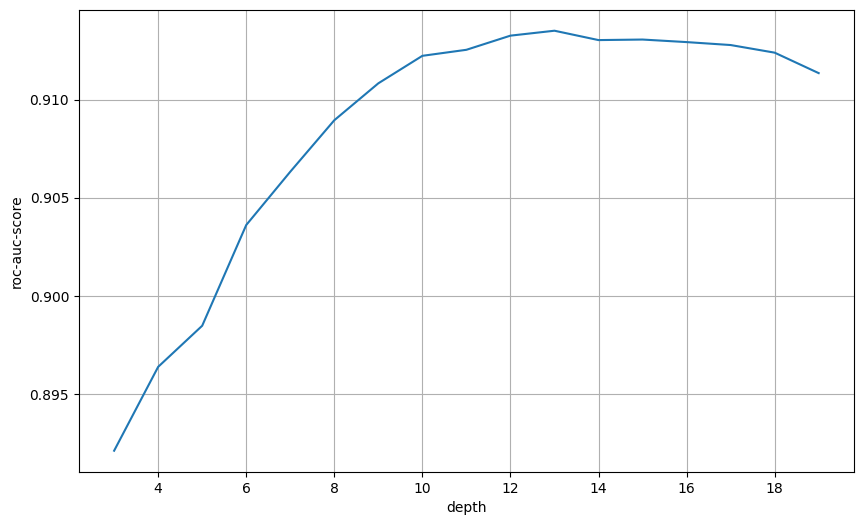

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [ ]:
best_depth = best_depht_result
test_data_for_forest.columns = test_data_for_forest.columns.astype(str)
model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)
model.fit(train_data_for_forest, y_train)


train_y_pred_forest = model.predict_proba(train_data_for_forest)[:, 1]
test_y_pred_forest = model.predict_proba(test_data_for_forest)[:, 1]
print(train_y_pred_forest, test_y_pred_forest, sep=', ')

[0.23826604 0.35547914 0.01195395 ... 0.97372106 0.46991412 0.0072747 ], [0.13031308 0.05158906 0.07249198 ... 0.24914606 0.11471941 0.02848371]


### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
train_auc = roc_auc_score(y_train, train_y_pred_forest)
test_auc = roc_auc_score(y_test, test_y_pred_forest)
print(train_auc, test_auc)

0.9627360663241911 0.9140712952678861


Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [ ]:
assert test_auc > 0.90

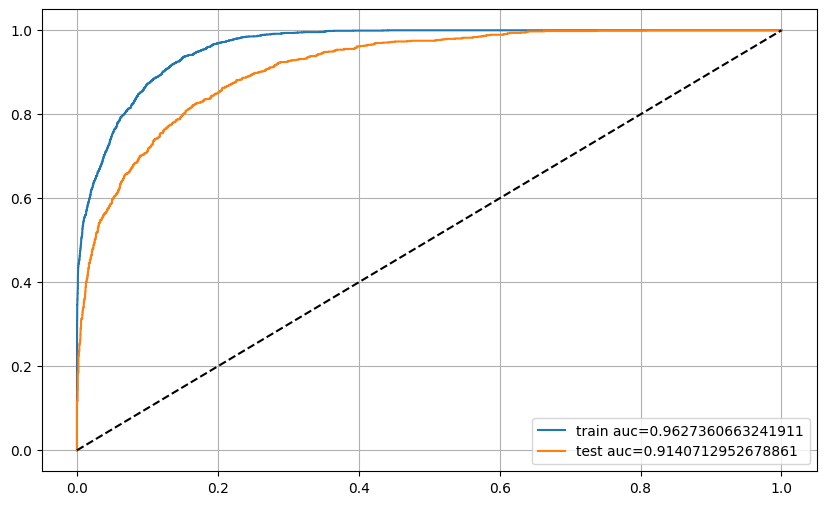

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_forest)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_forest)[:2],
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

In [ ]:
scoring_data_for_forest[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,0,1,2,3,...,50,51,52,53,54,55,56,57,58,59
0,17,256173,6,0,0,15,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,31,265706,13,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,61,244087,9,0,0,52,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,60,232618,9,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,56,34626,10,0,1980,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5,55,213615,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,25,245369,9,0,0,35,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,62,186696,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,39,165186,10,0,0,45,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,44,368757,10,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Задание
Создайте датасет `scoring_data_for_forest` и предскажите на нем целевую переменную.

In [ ]:
train_data_for_forest[:10]

In [ ]:

scoring_data_for_forest.columns = scoring_data_for_forest.columns.astype(str)
scoring_y_pred_forest = model.predict_proba(scoring_data_for_forest)[:, 1]
print(scoring_y_pred_forest)

[7.18156034e-04 7.80278519e-02 3.04863697e-01 ... 3.45453983e-02
 2.47479034e-01 7.70768439e-01]


Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [ ]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [ ]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования.
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`.

Для установки `catboost` вы можете выполнить следующую команду.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


Импортируем все необходимые классы.

In [ ]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [ ]:
train_cat_data = train_cat_data.fillna('unknown')
test_cat_data = test_cat_data.fillna('unknown')

In [ ]:
train_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10313 entries, 1729 to 6259
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       10313 non-null  object
 1   education       10313 non-null  object
 2   marital-status  10313 non-null  object
 3   occupation      10313 non-null  object
 4   relationship    10313 non-null  object
 5   race            10313 non-null  object
 6   sex             10313 non-null  object
dtypes: object(7)
memory usage: 644.6+ KB


### Задание
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков).

In [ ]:
train_data_for_boosting = pd.concat([train_real_data, train_cat_data], axis = 1)
test_data_for_boosting = pd.concat([test_real_data, test_cat_data], axis = 1)

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=train_data_for_boosting,
                     label=y_train,
                     cat_features=cat_features)

test_dataset = Pool(data=test_data_for_boosting,
                    cat_features=cat_features)

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`.

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [ ]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = cv(pool = train_dataset,
                params = params,
                fold_count=5,
                partition_random_seed=5)
    test_auc = scores['test-AUC-mean'].iloc[-1]

    boosting_metrics.append(test_auc)

Training on fold [0/5]

bestTest = 0.3248718785
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3358983279
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3227607211
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3206673752
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3269502592
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3184793746
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3306108473
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3147517773
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3135713513
bestIteration = 99

Training on fold [4/5]

bestTest = 0.319517124
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3137805257
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3258386557
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3098957527
bestIteration = 99

Training on fold [3/5]

bestTest = 0.308542775
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3155612325
be

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

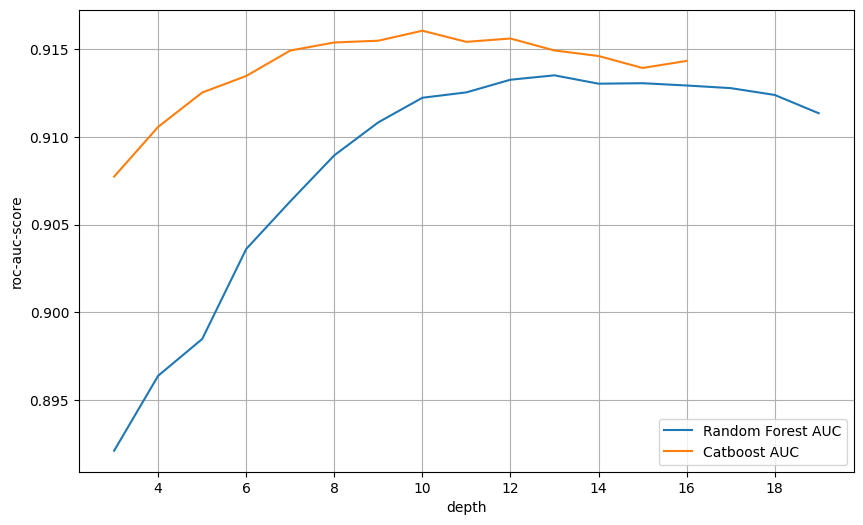

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга?
* Как она отличается от оптимальной глубины для бэггинга?

### Задание
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [ ]:
best_depth = np.argmax(boosting_metrics) + 3

model = CatBoostClassifier(iterations=500, depth=best_depth - 1, loss_function='Logloss',verbose=False)
model.fit(train_dataset)


train_y_pred_boosting = model.predict_proba(train_dataset)[ :, 1]
test_y_pred_boosting = model.predict_proba(test_dataset)[ :, 1]

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [ ]:
train_auc = roc_auc_score(y_train, train_y_pred_boosting)
test_auc = roc_auc_score(y_test, test_y_pred_boosting)
print(train_auc, test_auc)

0.9671319692814444 0.9203175376730921


Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [ ]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

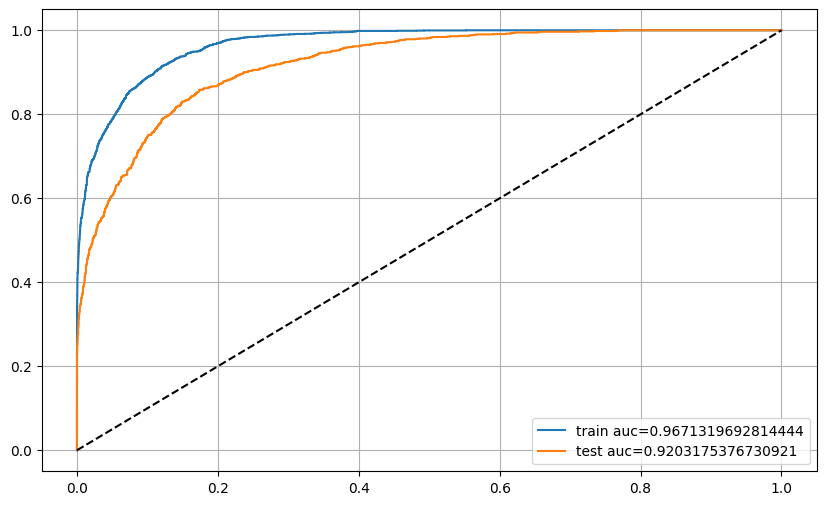

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2],
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [ ]:
scoring_data = scoring_data.fillna('unknown')

In [ ]:
scoring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1546 non-null   int64 
 1   workclass       1546 non-null   object
 2   fnlwgt          1546 non-null   int64 
 3   education       1546 non-null   object
 4   education-num   1546 non-null   int64 
 5   marital-status  1546 non-null   object
 6   occupation      1546 non-null   object
 7   relationship    1546 non-null   object
 8   race            1546 non-null   object
 9   sex             1546 non-null   object
 10  capital-gain    1546 non-null   int64 
 11  capital-loss    1546 non-null   int64 
 12  hours-per-week  1546 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 157.1+ KB


In [ ]:
scoring_data = pd.concat([scor_real_dat, scor_cat_dat], axis=1)
scoring_data = scoring_data.fillna('unknown')
cat_features = np.arange(scor_cat_dat.shape[1]) + scor_real_dat.shape[1]

scoring_dataset = Pool(data = scoring_data, cat_features=cat_features)

In [ ]:

scoring_y_pred_boosting = model.predict_proba(scoring_dataset)[ :, 1]
print(scoring_y_pred_boosting)

[4.40353299e-05 6.69318754e-02 1.32241054e-01 ... 9.82498754e-03
 6.04612485e-02 9.62723086e-01]


Сохраним предсказанные значения. Отправьте их на Stepik.

In [ ]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))